# Boro Player Predictions - Current Market Value

## 0. Setup

In [1]:
## standard library
import os
import re
import pickle
import shutil

In [2]:
## data wrangling
import numpy as np
import pandas as pd

In [3]:
## visualisation
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set()

In [4]:
## machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
## project src

In [6]:
## global constants
RANDOM_STATE = 4

## 1. Problem Definition

* Determine Busines Objectives
* Situation Assessment
* Determine Data Mining Goal
* Produce Project Plan

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

We have player data from Transfermarkt, ESPN, WhoScored and Fly Me To The Moon (fanzine).

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

## 2. Data Understanding

* Collect Initial Data
* Describe Data
* Explore Data
* Verify Data Quality

The first part of the data we'll look at is some general information on players, including their market value, as taken from Transfermarkt

In [7]:
def extract_season(file_name):
    """
    INPUT:
        file_name - String containing name of the data source file
        
    OUTPUT:
        season_out - String containing the formated label for the season
    """
    
    season_part = file_name.split(".")[0].split("_")[-1]
    season_out = season_part[:2] + "/" + season_part[-2:]
    
    return season_out

# extract_season?

In [8]:
extract_season("tmk_cnt_mbr_all_0910.csv")

'09/10'

In [9]:
def clean_data(source_name):
    """
    INPUT:
        source_name - String containing name of the data source
        
    OUTPUT:
        tmk_df - Dataframe containing the cleaned data
    """

    dir_tmk_cnt = "../data/raw/tmk/tmk_cnt/"
    data_list = []
    for file in os.listdir(dir_tmk_cnt):
        filepath = os.path.join(dir_tmk_cnt, file)
        print(filepath)
        tmp = pd.read_csv(filepath, encoding='latin-1', header=0, 
                          names=["Shirt number", "Position", "Name", "Date of birth", "Nationality",
                                "Height", "Foot", "Joined", "Signed from", "Contract expires",
                                "Market value"])
        tmp["Season"] = extract_season(file)
        data_list.append(tmp)

    tmk_df = pd.concat(data_list, axis=0, sort=False, ignore_index=True)

    ## Name and Position are mis-aligned in the source files
    
    tmk_df["Name"].fillna(method="bfill", inplace=True)

    tmk_df["Position"] = tmk_df.Name.shift(-1)
    tmk_df.loc[tmk_df.Position == tmk_df.Name, "Position"] = tmk_df.Name.shift(-2)

    tmk_df.drop(axis=1, columns=["Nationality", "Signed from"], inplace=True)

    tmk_df.dropna(subset=["Market value"], inplace=True)

    tmk_df = tmk_df.replace('-', np.nan)

    tmk_df["Shirt number"] = pd.to_numeric(tmk_df["Shirt number"], downcast='integer')

    tmk_df["Position group"] = None
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("KEEPER"))
            | (tmk_df.Position.str.upper().str.contains("GOAL")), 
           "Position group"] = "G"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("BACK"))
            | (tmk_df.Position.str.upper().str.contains("DEF")), 
           "Position group"] = "D"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("MID"))
            | (tmk_df.Position.str.upper().str.contains("MIT"))
            | (tmk_df.Position.str.upper().str.contains("WING")), 
           "Position group"] = "M"
    tmk_df.loc[(tmk_df.Position.str.upper().str.contains("STRIKER"))
            | (tmk_df.Position.str.upper().str.contains("FORW")), 
           "Position group"] = "F"

    tmk_df["Age"] = tmk_df["Date of birth"].str.extract(r".*([0-9]{2})", expand=False).astype("int")

    tmk_df["Date of birth"] = pd.to_datetime(
        tmk_df["Date of birth"].str.extract(r"(.*) \([0-9]{2}\)", expand=False), 
        format="%b %d, %Y")

    tmk_df["Joined"] = pd.to_datetime(tmk_df.Joined, format="%b %d, %Y")

    tmk_df["Contract expires"] = pd.to_datetime(tmk_df["Contract expires"], format="%d.%m.%Y")

    tmk_df["Height"] = (tmk_df["Height"] \
                              .str.strip() \
                              .str.replace(' ', '') \
                              .str.replace(',', '') \
                              .str.replace('m', '') \
                              .replace({'-':np.nan, '':np.nan}) \
                              .astype(float))
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Height.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Height.isna()].Name.values), "Height"] = \
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Height.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Height.isna()].Name.values)] \
        .sort_values(by=["Name", "Season"]).Height.fillna(method="bfill")
    
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Foot.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Foot.isna()].Name.values), "Foot"] = \
    tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Foot.notna()].Name.values)
           & tmk_df.Name.isin(tmk_df[tmk_df.Foot.isna()].Name.values)] \
        .sort_values(by=["Name", "Season"]).Foot.fillna(method="bfill")

    tmk_df["Market value"] = (tmk_df["Market value"] \
                              .str.strip() \
                              .replace({'-':np.nan}) \
                              .replace(r'[£km]', '', regex=True) \
                              .astype(float) * \
                tmk_df["Market value"].str.extract(r'[\d\.]+([km]+)', expand=False)
                    .fillna(1)
                    .replace(['k','m'], [10**3, 10**6]).astype(int) / 10**6)

    return tmk_df

# clean_data?

In [10]:
tmk_df = clean_data("tmk_cnt")
# tmk_df.info()

../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_0910.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1011.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1112.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1213.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1314.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1415.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1516.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1617.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1718.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1819.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1920.csv


In [11]:
tmk_df.sample(8, random_state=RANDOM_STATE)

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
240,16.0,Centre Forward,Bartholomew Ogbeche,1984-10-01,178.0,both,2011-10-01,NaT,0.450,11/12,F,26
518,7.0,Central Midfield,Grant Leadbitter,1986-01-07,177.0,right,2012-07-01,2017-06-30,1.500,15/16,M,30
611,13.0,Keeper,Tomás Mejías,1989-01-30,195.0,right,2014-07-05,2018-06-30,0.225,17/18,G,29
28,3.0,Left-Back,Andrew Taylor,1986-08-01,178.0,left,2005-07-01,NaT,1.880,09/10,D,22
274,2.0,Right-Back,Justin Hoyte,1984-11-20,180.0,right,2008-08-01,NaT,1.130,12/13,D,27
48,34.0,Defensive Midfield,Isaiah Osbourne,1987-11-05,188.0,right,2009-11-06,NaT,0.375,09/10,M,21
618,4.0,Centre-Back,Daniel Ayala,1990-11-07,190.0,right,2014-01-24,2020-06-30,1.800,17/18,D,27
198,3.0,Left-Back,Joe Bennett,1990-03-28,177.0,left,2008-07-01,NaT,0.188,11/12,D,21


In [12]:
tmk_df.describe(include="all")

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
count,333.000000,364,364,364,356.000000,324,351,169,330.000000,364,364,364.000000
unique,NaN,19,172,169,NaN,3,126,12,NaN,11,4,NaN
top,NaN,Centre Back,Ben Gibson,1993-01-15 00:00:00,NaN,right,2010-07-01 00:00:00,2020-06-30 00:00:00,NaN,09/10,M,NaN
freq,NaN,53,9,9,NaN,201,31,28,NaN,47,134,NaN
first,NaN,NaN,NaN,1973-08-27 00:00:00,NaN,NaN,2000-07-01 00:00:00,2016-05-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2000-08-09 00:00:00,NaN,NaN,2020-01-31 00:00:00,2023-06-30 00:00:00,NaN,NaN,NaN,NaN
mean,18.054054,NaN,NaN,NaN,183.286517,NaN,NaN,NaN,1.696327,NaN,NaN,24.826923
std,11.018471,NaN,NaN,NaN,6.028752,NaN,NaN,NaN,1.776398,NaN,NaN,4.696900
min,1.000000,NaN,NaN,NaN,167.000000,NaN,NaN,NaN,0.038000,NaN,NaN,16.000000
25%,8.000000,NaN,NaN,NaN,179.000000,NaN,NaN,NaN,0.375000,NaN,NaN,21.000000


**ANALYSIS** So the data is looking broadly in good shape, but there are a few missing values to consider...

In [13]:
tmk_df.count() / tmk_df.shape[0]

Shirt number        0.914835
Position            1.000000
Name                1.000000
Date of birth       1.000000
Height              0.978022
Foot                0.890110
Joined              0.964286
Contract expires    0.464286
Market value        0.906593
Season              1.000000
Position group      1.000000
Age                 1.000000
dtype: float64

**ANALYSIS** Only `Joined` has large gaps. Let's look at it in more detail...

In [14]:
tmk_df.loc[tmk_df.Name.isin(tmk_df[tmk_df.Joined.notna()].Name.values)
       & tmk_df.Name.isin(tmk_df[tmk_df.Joined.isna()].Name.values)].sort_values(by=["Name", "Season"])

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season,Position group,Age
156,41.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,NaT,NaT,NaN,10/11,M,17
220,32.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,NaN,11/12,M,18
300,25.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,NaN,12/13,M,19
374,NaN,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,0.188,13/14,M,20
454,20.0,Left Midfield,Adam Reach,1993-02-03,185.0,left,2011-07-01,2019-06-30,0.375,14/15,M,21
26,39.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,NaT,NaT,NaN,09/10,D,16
120,34.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,10/11,D,17
194,34.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,11/12,D,18
266,40.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,NaN,12/13,D,19
348,22.0,Centre Back,Ben Gibson,1993-01-15,185.0,left,2010-07-01,2019-06-30,0.188,13/14,D,20


**ANALYSIS** _Possibly_ we could back fill some missing `Joined` dates but this might have some downstream consequences because the date _might_ exceed the end of that season. We'll leave them as Nulls for now.

Next we'll look at the distributions of single fields with bar charts for categorical variables and histograms for numeric and date variables

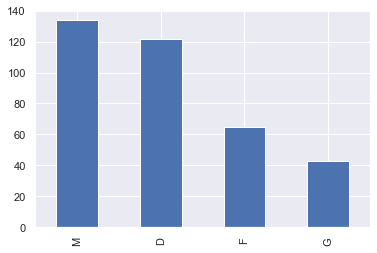

In [15]:
tmk_df["Position group"].value_counts().plot(kind='bar')

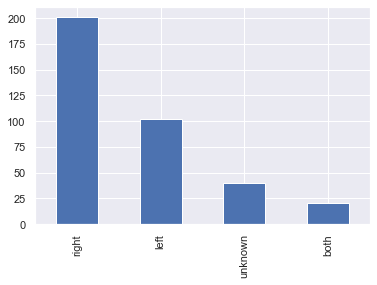

In [16]:
tmk_df.Foot.fillna("unknown").value_counts().plot(kind='bar')

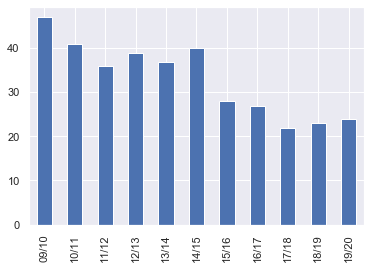

In [17]:
tmk_df.Season.value_counts().sort_index().plot(kind='bar')

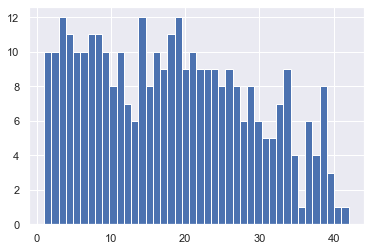

In [18]:
tmk_df["Shirt number"].hist(bins=42)

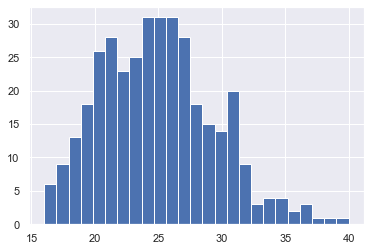

In [19]:
tmk_df["Age"].hist(bins=25)

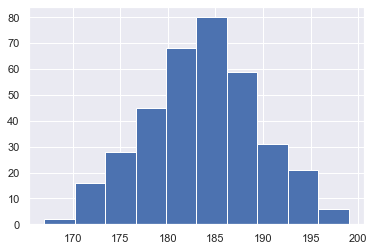

In [20]:
tmk_df["Height"].hist()

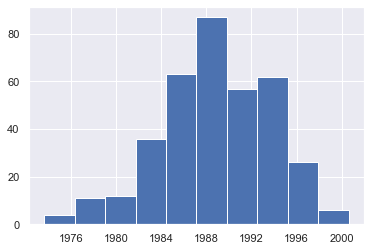

In [21]:
tmk_df["Date of birth"].hist()

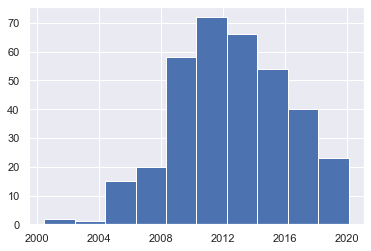

In [22]:
tmk_df["Joined"].hist()

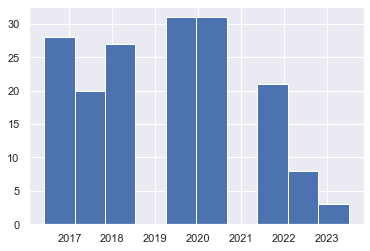

In [23]:
tmk_df["Contract expires"].hist()

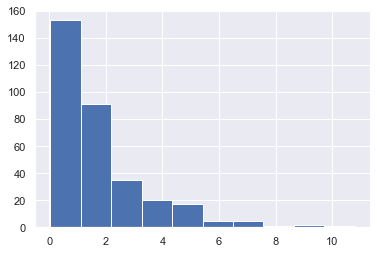

In [24]:
tmk_df["Market value"].hist()

We can explore simple relationships between variables using pairplots and histogram facet grids

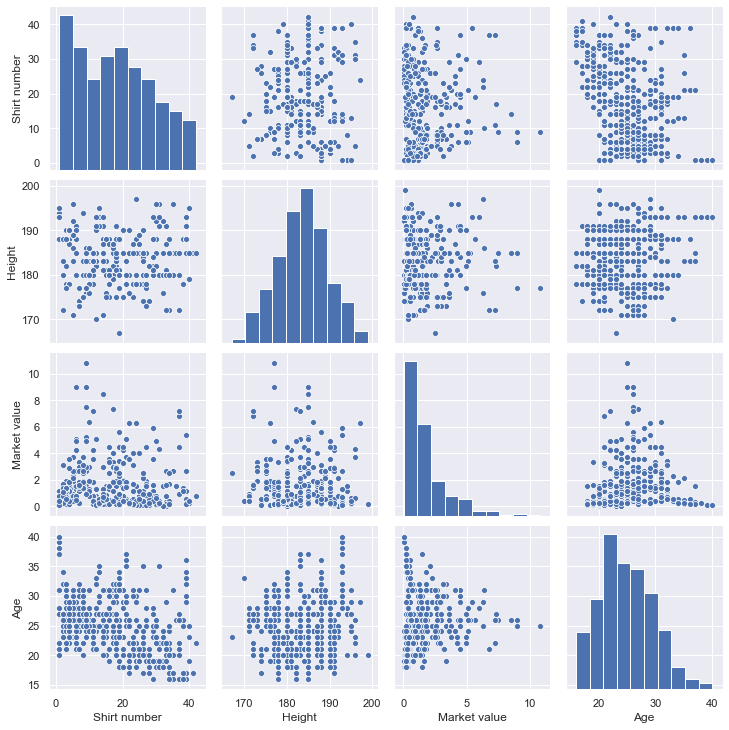

In [25]:
sns.pairplot(tmk_df)

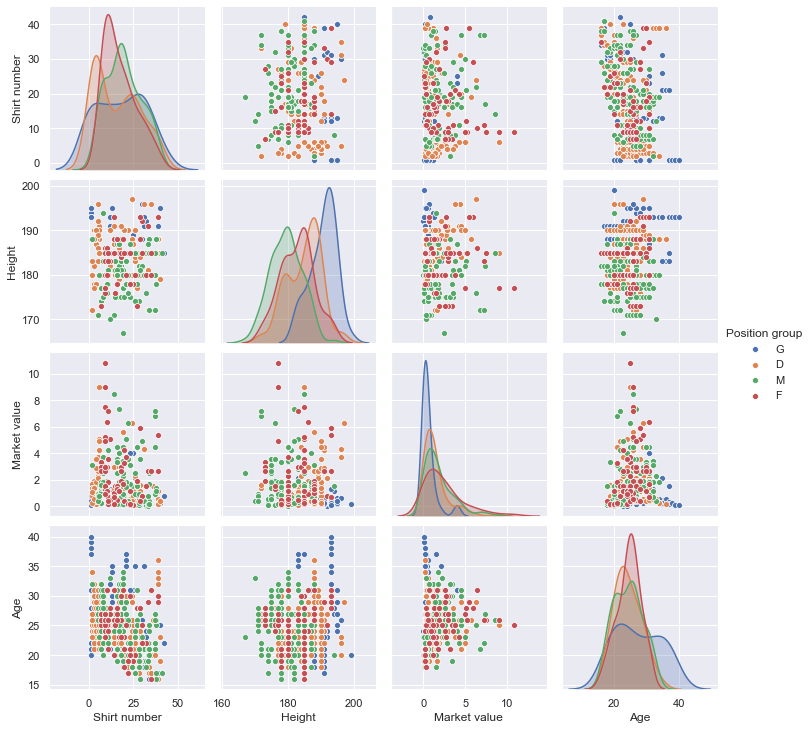

In [26]:
sns.pairplot(tmk_df, hue="Position group")

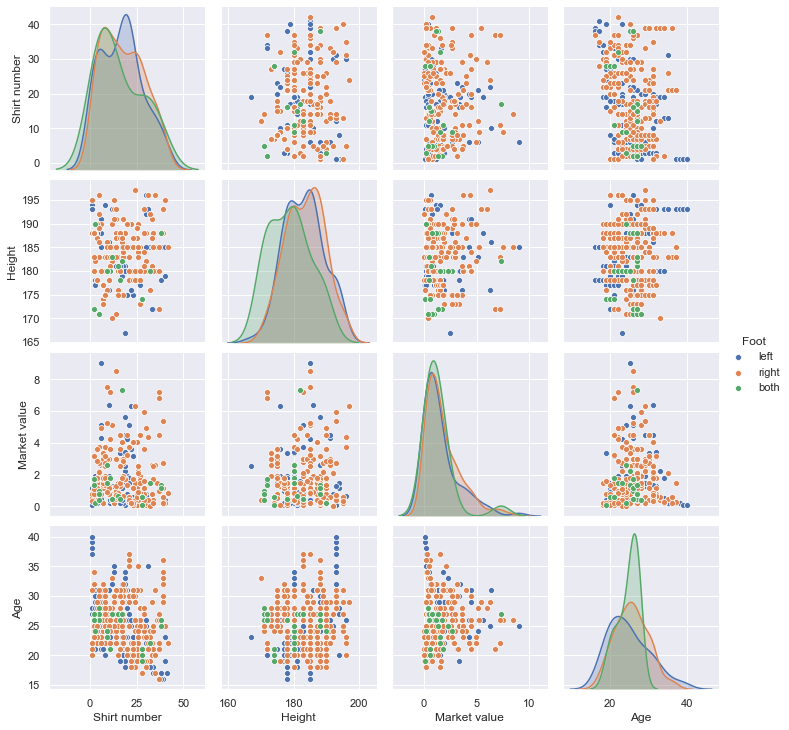

In [27]:
sns.pairplot(tmk_df, hue="Foot")

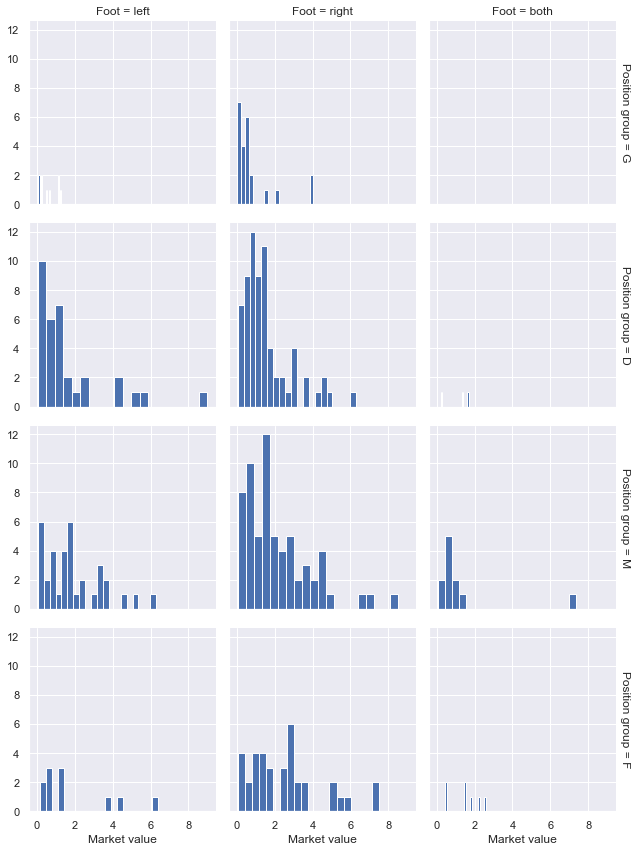

In [28]:
facet_grid = sns.FacetGrid(tmk_df, row="Position group", col="Foot", margin_titles=True)
facet_grid.map(plt.hist, "Market value", bins=20)

## 3. Data Preperation

* Select Data
* Clean Data
* Construct Data
* Integrate Data
* Format Data

In [29]:
df = tmk_df.copy()
df.shape

(364, 12)

In [30]:
df["Player key"] = df.Name + " (" + df.Season + ")"
df.set_index(df["Player key"], drop=True, inplace=True, verify_integrity=True)
df.drop(columns=["Player key"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, Brad Jones (09/10) to Rudy Gestede (19/20)
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Shirt number      333 non-null    float64       
 1   Position          364 non-null    object        
 2   Name              364 non-null    object        
 3   Date of birth     364 non-null    datetime64[ns]
 4   Height            356 non-null    float64       
 5   Foot              324 non-null    object        
 6   Joined            351 non-null    datetime64[ns]
 7   Contract expires  169 non-null    datetime64[ns]
 8   Market value      330 non-null    float64       
 9   Season            364 non-null    object        
 10  Position group    364 non-null    object        
 11  Age               364 non-null    int32         
dtypes: datetime64[ns](3), float64(3), int32(1), object(5)
memory usage: 35.5+ KB


We can derive some new numeric features to express relationships between dates

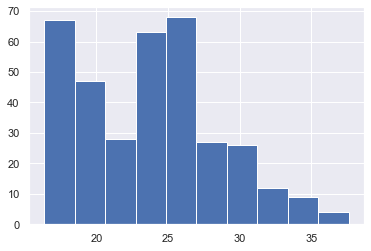

In [31]:
df["Age when joined"] = (df["Joined"] - df["Date of birth"])/ np.timedelta64(1, 'Y')
df["Age when joined"].hist()

**ANALYSIS** Most players join in their teens or mid-twenties.

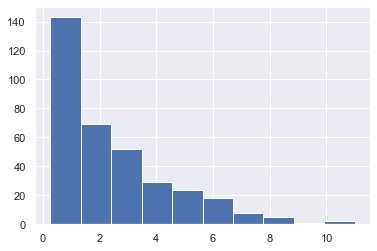

In [32]:
df["Years in team"] = (pd.to_datetime("1st July 20"+df.Season.str[-2:]) - df["Joined"])/ np.timedelta64(1, 'Y')
df["Years in team"].hist()

**ANALYSIS** I'm going to leave out `Shirt number`, `Position`, `Name`, `Date of birth`, `Joined`, `Season` and `Contract expires` from the model for now. `Contract expires` is populated in less than half of records. The others can be discarded for simplicity of model.

In [33]:
df.drop(columns=["Shirt number", "Position", "Name", "Date of birth", "Joined", "Season", "Contract expires"], inplace=True)
df.shape

(364, 7)

`Foot` and `Position group` will be one-hot encoded 

In [34]:
for var in ["Foot", "Position group"]:
    df = pd.concat(
        [
            df.drop(var, axis=1),
            pd.get_dummies(
                df[var], prefix=var, prefix_sep="=", drop_first=False
            ),
        ],
        axis=1,
    )

# df.describe()
df.shape

(364, 12)

In [35]:
df.sample(5, random_state=RANDOM_STATE)

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
Player key,,,,,,,,,,,,
Bartholomew Ogbeche (11/12),178.0,0.450,26,26.998501,0.750187,1,0,0,0,1,0,0
Grant Leadbitter (15/16),177.0,1.500,30,26.481037,4.000082,0,0,1,0,0,0,1
Tomás Mejías (17/18),195.0,0.225,29,25.426942,3.989131,0,0,1,0,0,1,0
Andrew Taylor (09/10),178.0,1.880,22,18.916200,4.999418,0,1,0,1,0,0,0
Justin Hoyte (12/13),180.0,1.130,27,23.696585,4.914543,0,0,1,1,0,0,0


In [36]:
df.describe()

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M
count,356.000000,330.000000,364.000000,351.000000,351.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000
mean,183.286517,1.696327,24.826923,23.871039,2.447119,0.057692,0.280220,0.552198,0.335165,0.178571,0.118132,0.368132
std,6.028752,1.776398,4.696900,4.733915,2.005552,0.233482,0.449725,0.497952,0.472698,0.383520,0.323208,0.482961
min,167.000000,0.038000,16.000000,16.356256,0.265577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,179.000000,0.375000,21.000000,19.409023,0.913092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,183.000000,1.130000,25.000000,23.907404,1.960341,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,188.000000,2.250000,28.000000,26.554960,3.422384,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,199.000000,10.800000,40.000000,37.607891,10.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


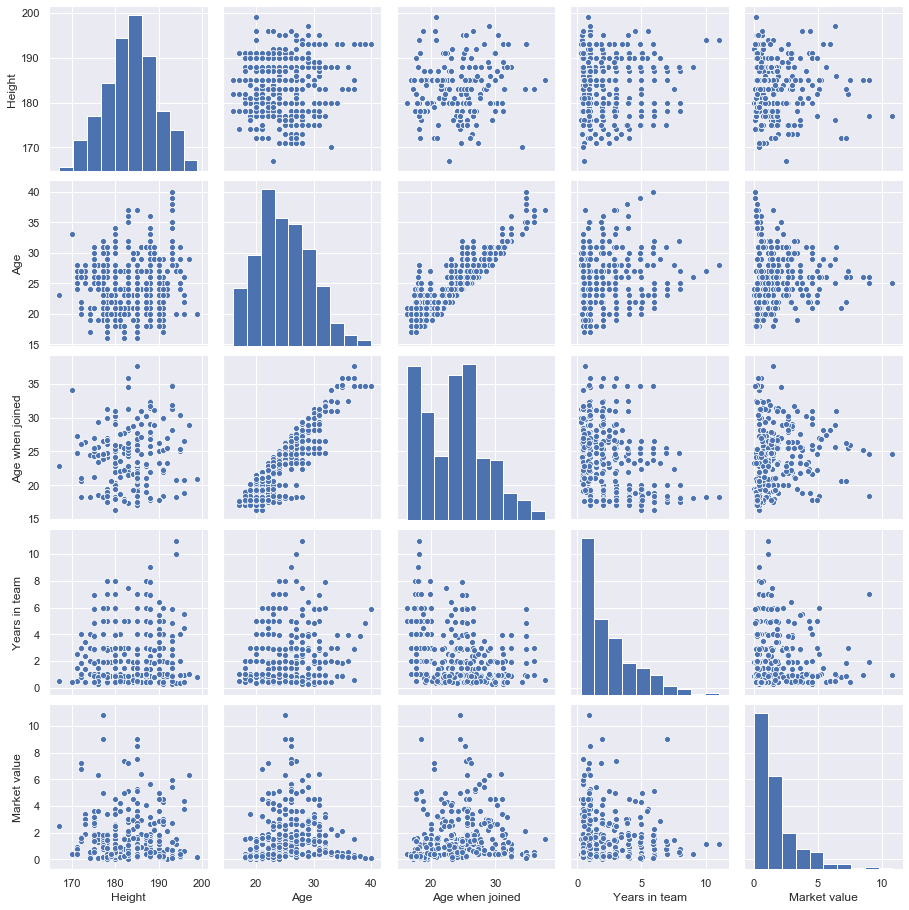

In [37]:
sns.pairplot(df[["Height", "Age", "Age when joined", "Years in team", "Market value"]])

In [38]:
df.columns

Index(['Height', 'Market value', 'Age', 'Age when joined', 'Years in team',
       'Foot=both', 'Foot=left', 'Foot=right', 'Position group=D',
       'Position group=F', 'Position group=G', 'Position group=M'],
      dtype='object')

## 4. Modelling

* Select Modelling Technique
* Generate Test Design
* Build Model
* Assess Model

In [39]:
feature_names = ['Height', 'Age', 'Age when joined', 'Years in team', 'Foot=both',
       'Foot=left', 'Foot=right', 'Position group=D', 'Position group=F',
       'Position group=G', 'Position group=M']
feature_names

['Height',
 'Age',
 'Age when joined',
 'Years in team',
 'Foot=both',
 'Foot=left',
 'Foot=right',
 'Position group=D',
 'Position group=F',
 'Position group=G',
 'Position group=M']

In [40]:
drop_nulls = True
drop_nulls

True

In [41]:
if drop_nulls:
    X = df[df.notna().all(axis=1)][feature_names]
    y = df[df.notna().all(axis=1)]["Market value"]
else:
    X = df[feature_names]
    y = df["Market value"]
    
X.shape, y.shape

((328, 11), (328,))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, train_size=0.9)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((295, 11), (33, 11), (295,), (33,))

In [43]:
number_of_folds = 10
number_of_folds

10

In [44]:
kfold = KFold(n_splits=number_of_folds, shuffle=True, random_state=RANDOM_STATE)
kfold

KFold(n_splits=10, random_state=4, shuffle=True)

In [45]:
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
param_grid = {"fit_intercept": [True, False],
             "normalize": [True, False],}
param_grid

{'fit_intercept': [True, False], 'normalize': [True, False]}

In [47]:
grid = GridSearchCV(model, param_grid, cv=kfold)
grid

GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [48]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=4, shuffle=True),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [49]:
grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [50]:
grid.score(X_train, y_train)

0.22316654965930327

**ANALYSIS** 0.223 isn't great - especially just on the training data - but it's a baseline. The only way is up (I Hope!) :)

In [51]:
final_model = grid.best_estimator_
final_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
final_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
final_model.score(X_train, y_train)

0.22316654965930327

**ANALYSIS** 

In [54]:
median_absolute_error(y_train, final_model.predict(X_train))

0.8494754034468113

In [55]:
mean_squared_error(y_train, final_model.predict(X_train), squared=False)

1.6009173277884379

In [56]:
r2_score(y_train, final_model.predict(X_train))

0.22316654965930327

**ANALYSIS** Baseline some other useful metrics

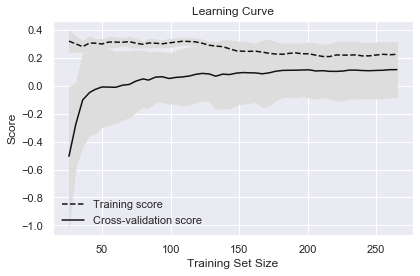

In [57]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(final_model, 
                                                        X_train, 
                                                        y_train,
                                                        cv=kfold,
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.1, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

**ANALYSIS** The model seems pretty weak in general but we can say the learning curves have largely converged so adding extra training samples is unlikely to improve the model.

## 5. Evaluation

* Evaluate Results
* Review Process
* Determine Next Steps

In [58]:
final_model.score(X_test, y_test)

0.010774658989811225

**ANALYSIS** As per the training score, the test data returns a pretty poor score of 0.01. Plenty to work on

In [59]:
median_absolute_error(y_test, final_model.predict(X_test))

0.9945309991577052

In [60]:
mean_squared_error(y_test, final_model.predict(X_test), squared=False)

1.376076969839843

In [61]:
r2_score(y_test, final_model.predict(X_test))

0.010774658989811225

**ANALYSIS** 

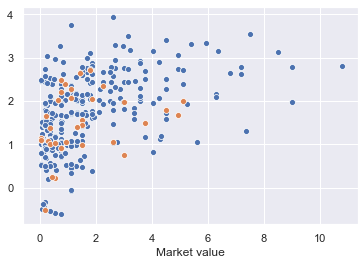

In [62]:
sns.scatterplot(y_train, final_model.predict(X_train))
sns.scatterplot(y_test, final_model.predict(X_test))

**ANALYSIS** Confirming our scoring visually, it looks pretty weak correlation between actual and predicted values. Note also the model is not able to predict anything much above £4m even though some of the data exceeded £10m.

In [63]:
params = pd.Series(final_model.coef_, index=X.columns)
# params

np.random.seed(1)
err = np.std([final_model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)
# err

pd.DataFrame({"effect": params.round(2), "error": err.round(2)})

,effect,error
Height,0.01,0.02
Age,1.11,0.21
Age when joined,-1.07,0.21
Years in team,-1.14,0.21
Foot=both,0.01,0.58
Foot=left,0.36,0.47
Foot=right,0.42,0.48
Position group=D,-0.07,0.13
Position group=F,0.89,0.21
Position group=G,-1.17,0.19


**ANALYSIS** The individual features which appear to have most effect are `Age`, `Age when joined`, `Years in team` and `Position group=G`. Perhaps the most we can say is old goalkeepers aren't worth much.

## 6. Deployment

* Plan Deployment
* Plan Monitoring and Maintenance
* Produce Final Report
* Review Project

In [64]:
df_out = df.copy()
df_out.shape

(364, 12)

In [65]:
if drop_nulls:
    df_out["Market value (prediction)"] = np.NaN
    df_out.loc[df_out.notna()[feature_names].all(axis=1), "Market value (prediction)"] = final_model.predict(df_out[df_out.notna()[feature_names].all(axis=1)][feature_names])
else:
    df_out["Market value (prediction)"] = final_model.predict(df_out[feature_names])

df_out.shape

(364, 13)

In [66]:
df_out.describe()

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
count,356.000000,330.000000,364.000000,351.000000,351.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,364.000000,347.000000
mean,183.286517,1.696327,24.826923,23.871039,2.447119,0.057692,0.280220,0.552198,0.335165,0.178571,0.118132,0.368132,1.659529
std,6.028752,1.776398,4.696900,4.733915,2.005552,0.233482,0.449725,0.497952,0.472698,0.383520,0.323208,0.482961,0.916826
min,167.000000,0.038000,16.000000,16.356256,0.265577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.344257
25%,179.000000,0.375000,21.000000,19.409023,0.913092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.937653
50%,183.000000,1.130000,25.000000,23.907404,1.960341,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.596059
75%,188.000000,2.250000,28.000000,26.554960,3.422384,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.330483
max,199.000000,10.800000,40.000000,37.607891,10.998172,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.218156


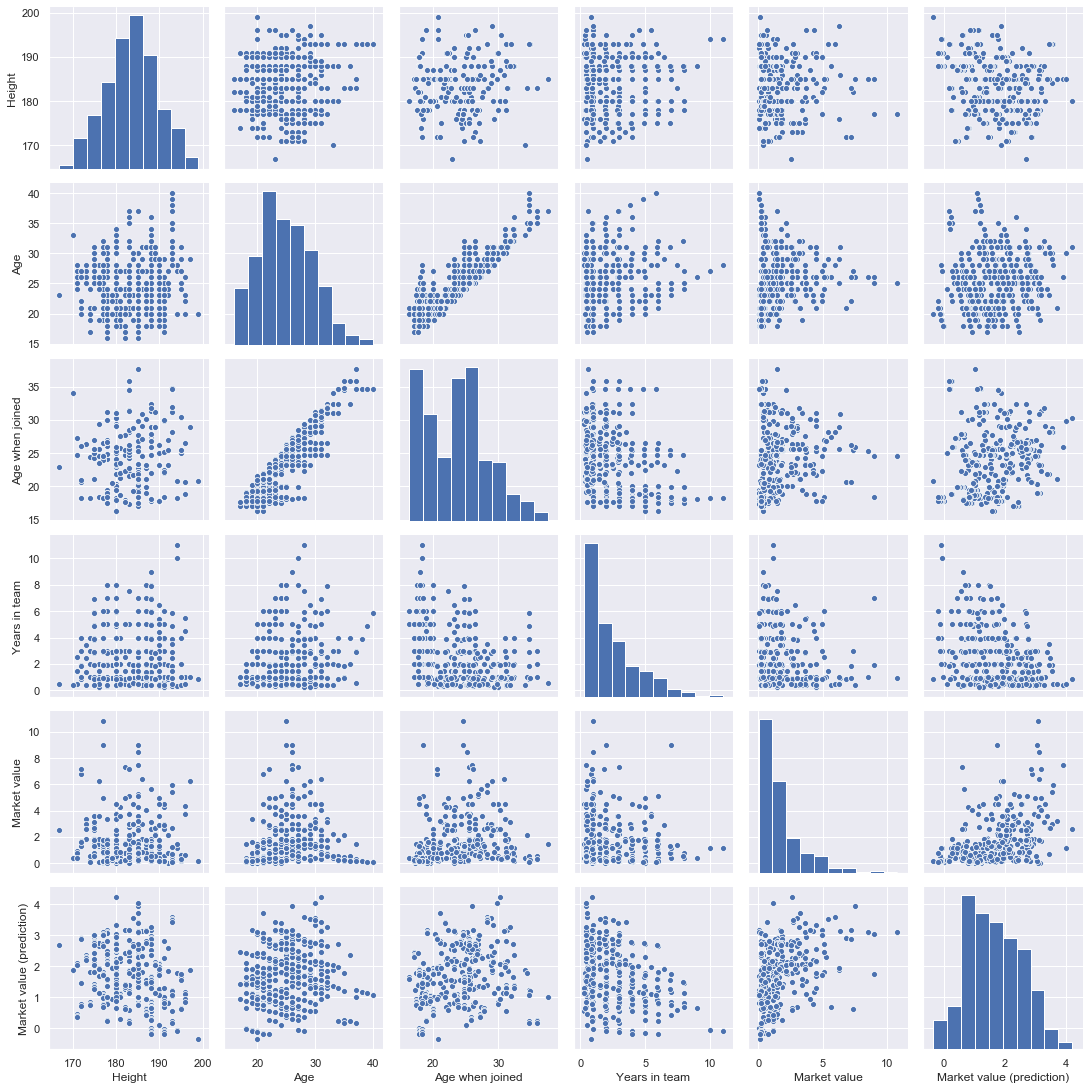

In [67]:
sns.pairplot(df_out[["Height", "Age", "Age when joined", "Years in team", "Market value", "Market value (prediction)"]])

**ANALYSIS** As we saw during data preperation there's no clear correlations with continuous features at work. Further our predictions don't even particularly correlate with the actual values.

In [68]:
df_unseen = df_out[df_out["Market value"].isna()]
df_unseen.shape

(34, 13)

In [69]:
df_unseen[df_unseen["Market value (prediction)"].notna()].describe()

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
count,19.000000,0.0,19.000000,19.000000,19.000000,19.0,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,182.578947,NaN,18.736842,18.809421,1.431925,0.0,0.421053,0.315789,0.315789,0.157895,0.052632,0.473684,1.305653
std,5.766915,NaN,1.284182,1.398387,0.980438,0.0,0.507257,0.477567,0.477567,0.374634,0.229416,0.512989,0.683406
min,172.000000,NaN,17.000000,17.054423,0.334025,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.037862
25%,180.000000,NaN,18.000000,17.831988,0.915830,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.908761
50%,183.000000,NaN,18.000000,18.404211,0.999336,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.325046
75%,185.000000,NaN,20.000000,19.280341,2.000041,0.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.467859
max,196.000000,NaN,21.000000,21.881353,4.000082,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.049585


In [70]:
df_unseen[df_unseen["Market value (prediction)"].notna()]

,Height,Market value,Age,Age when joined,Years in team,Foot=both,Foot=left,Foot=right,Position group=D,Position group=F,Position group=G,Position group=M,Market value (prediction)
Player key,,,,,,,,,,,,,
Jay O'Shea (09/10),183.0,NaN,20,21.555542,0.334025,0,0,1,0,0,0,1,1.325046
Ben Gibson (10/11),185.0,NaN,17,17.456895,0.999336,0,1,0,1,0,0,0,0.933638
Richard Smallwood (10/11),180.0,NaN,19,19.504850,0.999336,0,0,0,0,0,0,1,1.075825
Luke Williams (10/11),185.0,NaN,17,17.054423,0.999336,0,0,0,0,1,0,0,2.472767
Connor Ripley (11/12),191.0,NaN,18,18.376832,1.002074,0,0,0,0,0,1,0,-0.037862
Ben Gibson (11/12),185.0,NaN,18,17.456895,2.001410,0,1,0,1,0,0,0,0.883883
Cameron Park (11/12),178.0,NaN,18,18.984647,1.002074,0,1,0,0,0,0,1,0.863075
Adam Reach (11/12),185.0,NaN,18,18.404211,1.002074,0,1,0,0,0,0,1,1.482308
Alex Nimely (11/12),180.0,NaN,20,20.309794,0.832324,0,0,1,0,1,0,0,3.049585


**ANALYSIS** The player's missing actual Market values are all young players (17-21). The predictions are typically quite small which is as expected at least. Poor Connor Ripley (11/12) gets a negative value!

In [71]:
df_out.to_csv("../data/interim/boro_01_dataset.csv")

In [72]:
clf_file = "../models/boro_01_model.pkl" 
with open(clf_file, "wb") as clf_outfile:
    pickle.dump(final_model, clf_outfile)

In [73]:
ftn_file = "../models/boro_01_feature_names.pkl" 
with open(ftn_file, "wb") as ftn_outfile:
    pickle.dump(feature_names, ftn_outfile)

In [74]:
## save notebook before running `nbconvert`

In [75]:
outFolder = './output'
for filename in os.listdir(outFolder):
    file_path = os.path.join(outFolder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [76]:
!jupyter nbconvert --no-input --output-dir='./output' --to markdown boro_01_current_market_value.ipynb

[NbConvertApp] Converting notebook boro_01_current_market_value.ipynb to markdown
[NbConvertApp] Support files will be in boro_01_current_market_value_files\
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbConvertApp] Making directory ./output\boro_01_current_market_value_files
[NbCon

In [77]:
!jupyter nbconvert --output-dir='./output' --to python boro_01_current_market_value.ipynb

[NbConvertApp] Converting notebook boro_01_current_market_value.ipynb to python
[NbConvertApp] Writing 17346 bytes to ./output\boro_01_current_market_value.py
